In [1]:
import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)
import system.robot as robotSystem
import numpy as np
import casadi as ca
from alpha_reach import Params as alpha_opt_params
import matplotlib.pyplot as plt
from system.controllers import RobotControllers as rcontrollers

In [2]:
alpha = robotSystem.RobotDynamics()
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
path_to_urdf = os.path.join(
    project_root,
    'usage',
    'urdf','reach_alpha_5',
    'alpha_5_robot.urdf'
)
alpha.from_file(path_to_urdf)

root = "base_link"
tip = "alpha_standard_jaws_base_link"

kinematic_dict, K, P, L, D, C, g, B, qdd, joint_torque, sys_id_coeff , F_payload = alpha.build_model(root, tip,
                                                                                                      floating_base=False, 
                                                                                                      has_endeffector=False)
c_parms, m_params, I_params, fv_coeff, fc_coeff, fs_coeff, v_s_coeff, vec_g, r_com_payload, m_p, q, q_dot, q_dotdot, tau, base_pose, world_pose, tip_offset_pose = kinematic_dict['parameters']

In [3]:
arm_controllers = rcontrollers(4, alpha)

pid_controller, controller_arg = arm_controllers.build_arm_pid()

pid_u,_,_ = pid_controller(*controller_arg)
# pid_u = [0.0, 0.0, 0.0, 0.0]

rollout_arg = [alpha.F_next_reg_sys_arg[0], alpha.F_next_reg_sys_arg[2], alpha.F_next_reg_sys_arg[3], alpha.F_next_reg_sys_arg[4], alpha.F_next_reg_sys_arg[5]] + controller_arg[2:]
step_fn = ca.Function('step_fn', rollout_arg, 
                                [alpha.F_next_reg(alpha.F_next_reg_sys_arg[0],
                                                  pid_u,
                                                  alpha.F_next_reg_sys_arg[2],
                                                  alpha.F_next_reg_sys_arg[3],
                                                  alpha.F_next_reg_sys_arg[4],
                                                  alpha.F_next_reg_sys_arg[5])] )
N = 1000
# -----------------------
# mapaccum rollout: returns outputs only (x1..xN)
# -----------------------
Xk_rollout = step_fn.mapaccum(N)        # 8 x N
rollout_arg

[SX([q_0, q_1, q_2, q_3, q_dot_0, q_dot_1, q_dot_2, q_dot_3]),
 SX(dt),
 SX([m_i_0, m_i_1, m_i_2, m_i_3, m_r_ci_0_0, m_r_ci_0_1, m_r_ci_0_2, m_r_ci_1_0, m_r_ci_1_1, m_r_ci_1_2, m_r_ci_2_0, m_r_ci_2_1, m_r_ci_2_2, m_r_ci_3_0, m_r_ci_3_1, m_r_ci_3_2, Ixx_lumped_0, Iyy_lumped_0, Izz_lumped_0, Ixy_lumped_0, Ixz_lumped_0, Iyz_lumped_0, Ixx_lumped_1, Iyy_lumped_1, Izz_lumped_1, Ixy_lumped_1, Ixz_lumped_1, Iyz_lumped_1, Ixx_lumped_2, Iyy_lumped_2, Izz_lumped_2, Ixy_lumped_2, Ixz_lumped_2, Iyz_lumped_2, Ixx_lumped_3, Iyy_lumped_3, Izz_lumped_3, Ixy_lumped_3, Ixz_lumped_3, Iyz_lumped_3, fv_0, fv_1, fv_2, fv_3, fc_0, fc_1, fc_2, fc_3, fs_0, fs_1, fs_2, fs_3, v_s_0, v_s_1, v_s_2, v_s_3, vec_g_0, vec_g_1, vec_g_2, r_com_payload_0, r_com_payload_1, r_com_payload_2, m_p, base_xyz_0, base_xyz_1, base_xyz_2, base_rpy_0, base_rpy_1, base_rpy_2, world_x, world_y, world_z, world_roll, world_pitch, world_yaw, tip_offset_pose_0, tip_offset_pose_1, tip_offset_pose_2, tip_offset_pose_3, tip_offset_pose_4, ti

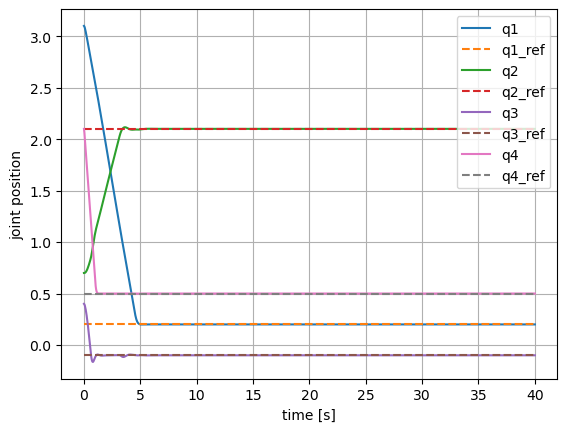

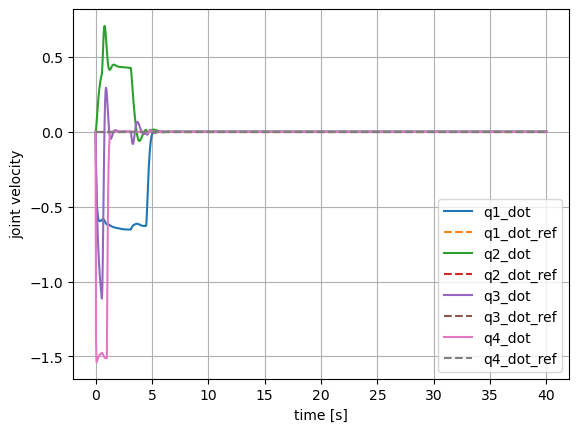

In [4]:
step_model_params = ca.DM([
    1.94000000e-01, 4.29000000e-01, 1.14999999e-01, 3.32999998e-01,
    -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -4.29000003e-02,
    1.96649101e-02, 4.29000003e-02, 2.88077923e-03, 7.23516749e-03,
    9.16434754e-03, 2.16416476e-03, -1.19076924e-03, 8.07346553e-03,
    7.10109586e-01, 7.10109586e-01, 1.99576149e-06, -0.00000000e+00,
    -0.00000000e+00, -0.00000000e+00, 1.10178508e-01, 1.83331277e-01,
    1.04292121e-01, -3.32240937e-02, -8.30350362e-02, -3.83631263e-02,
    1.18956416e-01, 1.22363853e-01, 4.34411664e-03, -3.96112974e-04,
    -2.13904668e-02, -1.77228242e-03, 1.92510932e-02, 2.56548460e-02,
    7.17220917e-03, 1.48789886e-03, 4.53687373e-04, -1.09861913e-03,
    2.39569756e+00, 2.23596482e+00, 8.19671021e-01, 3.57249665e-01,
    0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
    -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
    0,0,0,0,  0,0,0,  0,0,0,  0.0,  0,0,0,0,0,0,  0,0,0,0,0,0,  0.00, 0.00, 0.04, 0.00, 0.00, 0.00
])

# # rigid_p = ca.vertcat(self._sys_id_coeff["masses_id_syms_vertcat"],
# #                       self._sys_id_coeff["first_moments_id_vertcat"], 
# #                       self._sys_id_coeff["inertias_id_vertcat"],
# #                       self._sys_id_coeff["fv_id_vertcat"], 
# #                       self._sys_id_coeff["fc_id_vertcat"], 
# #                       self._sys_id_coeff["fs_id_vertcat"], 
# #                       v_s_coeff, vec_g, r_com_payload, m_p, base_pose, world_pose, tip_offset_pose)


# -----------------------
# Settings
# -----------------------
N = 1000
step_dt = 0.04

# Initial state (8x1)
x0 = ca.DM([3.1, 0.7, 0.4, 2.1, 0, 0, 0, 0]).reshape((8, 1))

# Constant inputs (as columns)
lock_mask_col = ca.DM.zeros(4, 1)
q_ref_col     = ca.DM([0.2, 2.1, -0.1, 0.5]).reshape((4, 1))
Kp_col        = ca.DM([10, 10, 10, 3]).reshape((4, 1))
Ki_col        = ca.DM([0, 0, 0, 0]).reshape((4, 1))
Kd_col        = ca.DM([0, 0, 0, 0]).reshape((4, 1))
sum_e_col     = ca.DM([0, 0, 0, 0]).reshape((4, 1))

u_min_col     = ca.DM([-1.5, -1.0, -1.0, -0.54]).reshape((4, 1))
u_max_col     = ca.DM([ 1.5,  1.0,  1.0,  0.54]).reshape((4, 1))

baumgarte_alpha = 200.0
i_dt = 0.04

# Model parameters must be 81x1,
p_col = ca.DM(step_model_params).reshape((81, 1))

# -----------------------
# Rollout
# (x0, dt, p, lock_mask, baumgarte_alpha, q_ref, Kp, Ki, Kd, sum_e, i_dt, u_max, u_min)
# -----------------------
Xk = Xk_rollout(
    x0,
    step_dt,
    p_col,
    lock_mask_col,
    baumgarte_alpha,
    q_ref_col,
    Kp_col,
    Ki_col,
    Kd_col,
    sum_e_col,
    i_dt,
    u_max_col,
    u_min_col,
)  # returns 8xN (x1..xN)

# Prepend x0 so history starts at initial condition
X_all = ca.horzcat(x0, Xk)             # 8x(N+1)

X_roll = np.array(ca.DM(X_all)).T      # (N+1)x8
q_hist  = X_roll[:, :4]
qd_hist = X_roll[:, 4:]

t_hist = step_dt * np.arange(q_hist.shape[0], dtype=float)

# -----------------------
# Plots
# -----------------------
q_ref_np = np.array(q_ref_col).ravel()
qd_ref_np = np.zeros(4)   # assuming zero velocity reference

# Joint positions
plt.figure()
for j in range(4):
    plt.plot(t_hist, q_hist[:, j], label=f"q{j+1}")
    plt.plot(t_hist, np.ones_like(t_hist) * q_ref_np[j],
             linestyle='--',
             label=f"q{j+1}_ref")

plt.xlabel("time [s]")
plt.ylabel("joint position")
plt.legend()
plt.grid(True)

# Joint velocities
plt.figure()
for j in range(4):
    plt.plot(t_hist, qd_hist[:, j], label=f"q{j+1}_dot")
    plt.plot(t_hist, np.ones_like(t_hist) * qd_ref_np[j],
             linestyle='--',
             label=f"q{j+1}_dot_ref")

plt.xlabel("time [s]")
plt.ylabel("joint velocity")
plt.legend()
plt.grid(True)

plt.show()
